#EDA

###Loading the data from kaggle

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c LANL-Earthquake-Prediction

Unzip the dataset

In [ ]:
!unzip /content/LANL-Earthquake-Prediction.zip

Importing the libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LinearRegression
from scipy.stats import skew
from scipy.stats import kurtosis
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

###Loading the dataset


In [ ]:
df = pd.read_csv("train.csv",nrows=100000000)
#df =  pd.read_csv("train.csv")
df.head(7)

In [ ]:
df.shape

(100000000, 2)

In [ ]:
df.info()

In [ ]:
df.isnull().sum()

####No null or NaN value found in acoustic_data column and time_to_failure column

####PDF and Histogram of acoustic_data

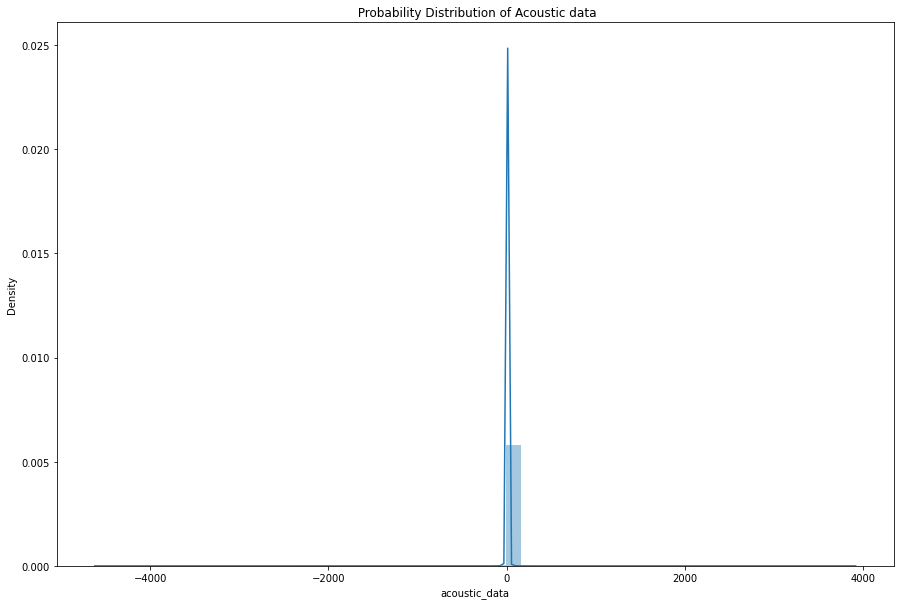

In [ ]:
plt.figure(figsize=(15,10))
plt.title(" Probability Distribution of Acoustic data")
sns.distplot(df["acoustic_data"])

The PDF of Acoustic data is very narrow and maybe range between 100 to -100.

To get a better view, we will use histogram.

In [ ]:
min(df["acoustic_data"]) , max(df["acoustic_data"])

(-4621, 3914)

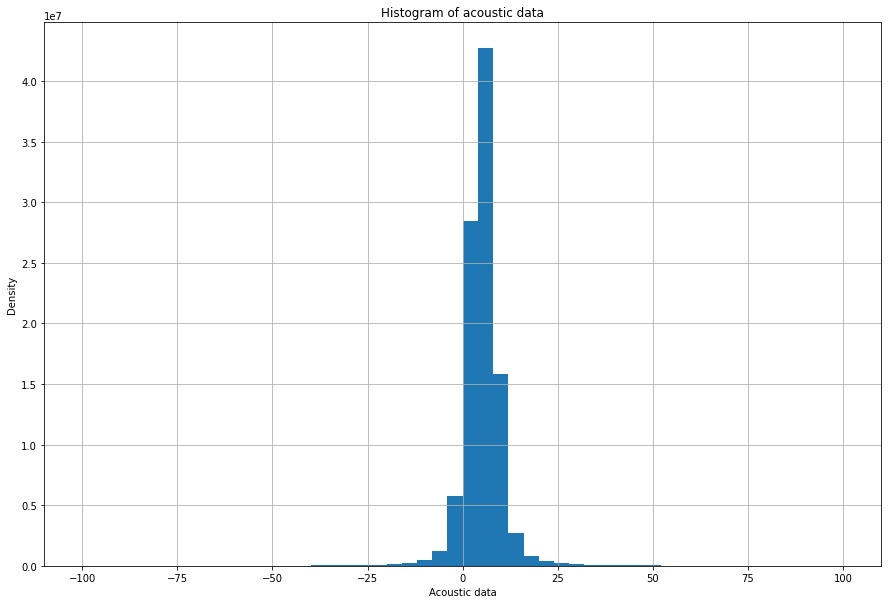

In [ ]:
plt.figure(figsize=(15,10))
df['acoustic_data'].hist(bins=50, range = [-100 , 100], align='mid')
plt.title("Histogram of acoustic data")
plt.xlabel('Acoustic data')
plt.ylabel('Density')
plt.show()

Here we can see that mmostly the data lies between -50 to 50. 

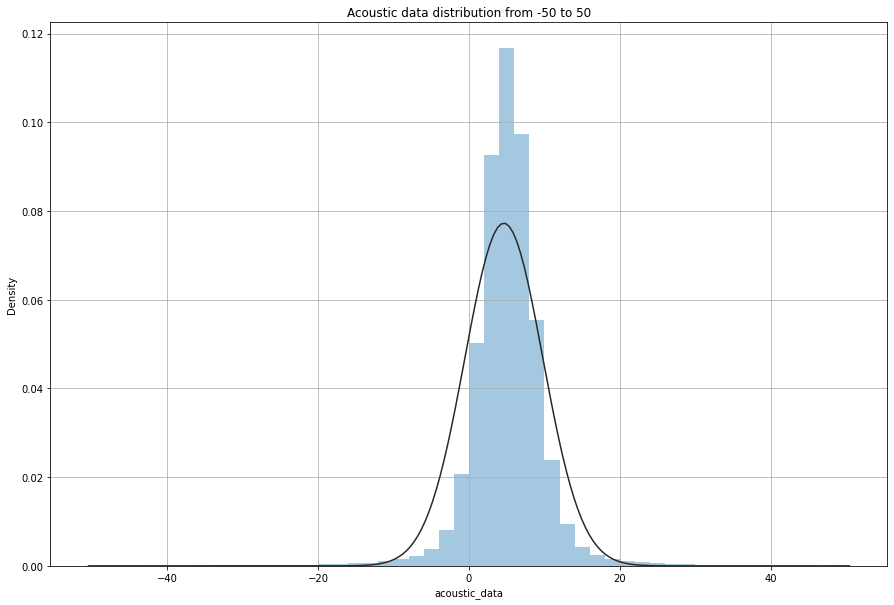

In [ ]:
#https://pandas.pydata.org/docs/reference/api/pandas.Series.between.html
plt.figure(figsize=(15,10))
plt.title("Acoustic data distribution from -50 to 50")
plt.ylabel('Density')
plt.grid()
ax = sns.distplot(df["acoustic_data"][df["acoustic_data"].between(-50 , 50)] , kde=False, fit=stats.norm)

Here we can see that most of the data lie between -20 to 20.

From the pdf and above code we can see that max and min value is 33914 and -4621 respectively which are outliers.

The dataframe (df) range between (-4621, 3914) and most of the data lies between -20 to 20. 

Therefore,  from the plots we can conclude that there are many outliers present in the dataset.

#PDF and Histogram of time_to_failure

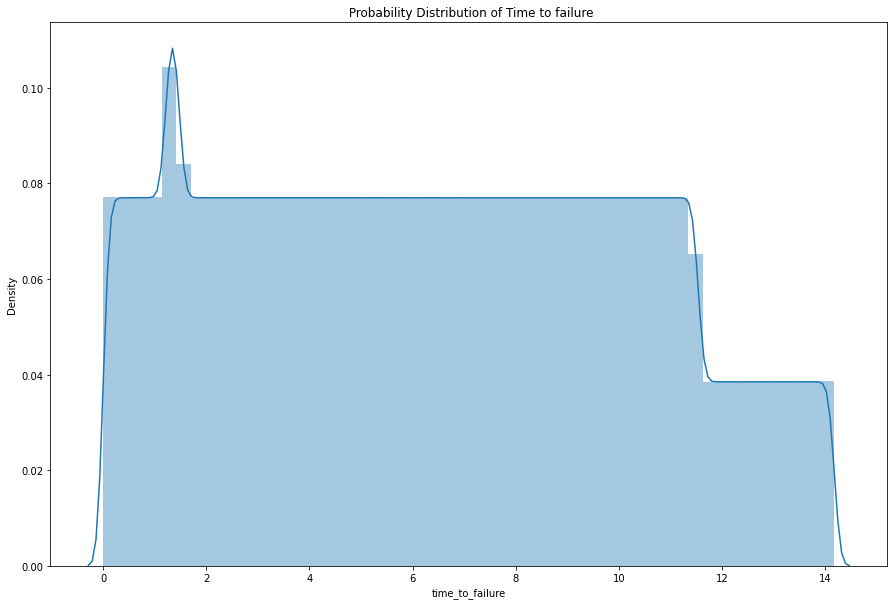

In [ ]:
plt.figure(figsize=(15,10))
plt.title(" Probability Distribution of Time to failure")
sns.distplot(df["time_to_failure"])

In [ ]:
max(df['time_to_failure'])

14.18059999

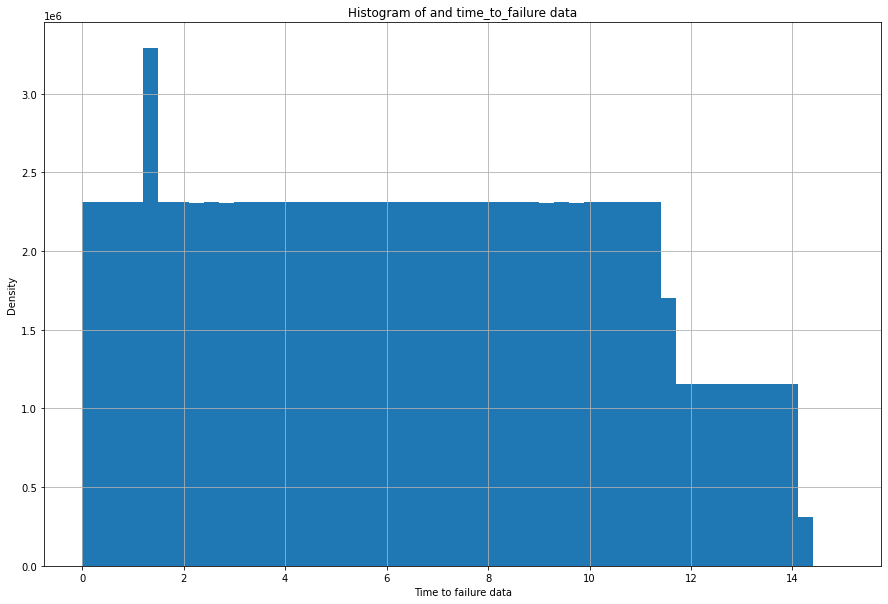

In [ ]:
plt.figure(figsize=(15,10))
df['time_to_failure'].hist(bins=50, range = [0 , 15], align='mid')
plt.title("Histogram of and time_to_failure data")
plt.xlabel('Time to failure data')
plt.ylabel('Density')
plt.show()

The value of time to failure ranges from 0 to 15 approx.

In [ ]:
def timeseries(final_index1, final_index2, step=1, title = ""): 
    index1 = [i for i in range(0, final_index1, step)] 
    index2 = [i for i in range(0, final_index2, step)] 
    fig, (ax1x, ax2x) = plt.subplots(1,2, figsize=(20,8))
    fig.subplots_adjust() 
    ax1y = ax1x.twinx() 
    ax2y = ax2x.twinx() 
    ax1x.set_xlabel("Index") 
    ax1x.set_ylabel("Acoustic data") 
    ax2x.set_ylabel("Time to failure") 
    
    p1 = sns.lineplot(data = df.iloc[index1]["acoustic_data"].values,   ax = ax1x, color=  "orange")
    p2 = sns.lineplot(data = df.iloc[index1]["time_to_failure"].values, ax = ax1y, color = "blue")
    p3 = sns.lineplot(data = df.iloc[index2]["acoustic_data"].values,   ax = ax2x, color = "orange") 
    p4 = sns.lineplot(data = df.iloc[index2]["time_to_failure"].values, ax = ax2y, color = "blue")

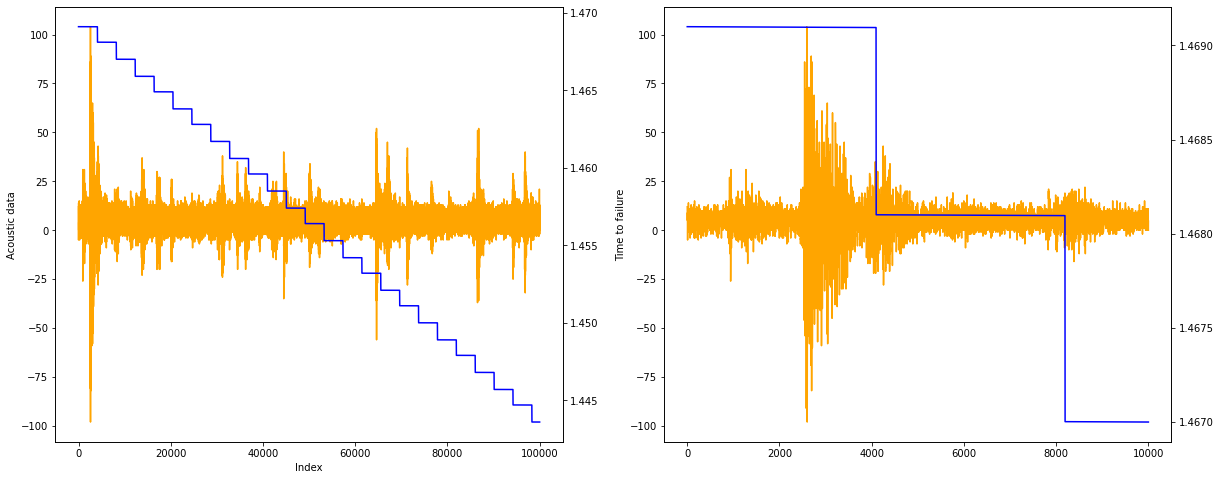

In [ ]:
timeseries(100000, 10000 ,  title = "10k and 100K rows")

From the above fighures, We can see that time to failure is a linear function. 

#Dickey Fuller Tests

In [ ]:
#https://www.youtube.com/watch?v=warCSvy1DMk&t=367s
X = df["time_to_failure"].sample(frac = 0.001).values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")

ADF Statistic: -315.081303
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
Reject Ho - Time Series is Stationary


With Dickey Fuller Tests, we can say that Time series is Stationary.

##Adding new features


In [ ]:
#Ading features
def feat(x):
    features = {}
    features['Mean'] = x.mean()
    features['Std'] = x.std()
    features['max value'] = x.max()
    features['min value'] = x.min()
    features['kurtosis']  = x.kurtosis()
    features['skew'] = x.skew()

    return features


In [ ]:
from tqdm import tqdm
rows = 150000
feature = []
y = []
for i in tqdm(range(int(np.floor(df.shape[0] / rows)))):
    
    x = df.iloc[i*rows :i*rows + rows]
    y.append(x.time_to_failure.values[-1])
    
    feature.append(feat(x["acoustic_data"]))
feat = pd.DataFrame(feature)

100%|██████████| 666/666 [00:02<00:00, 244.83it/s]


In [ ]:
feat.head(2)

,Mean,Std,max value,min value,kurtosis,skew
0,4.884113,5.101106,104,-98,33.662481,-0.024061
1,4.725767,6.588824,181,-154,98.758517,0.390561


In [ ]:
feat['time_to_failure'] = y

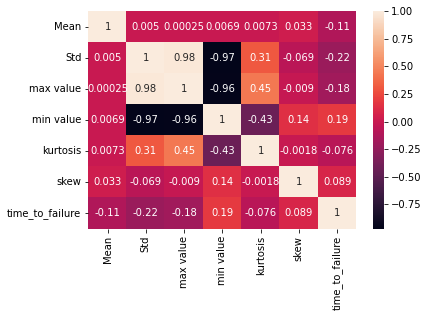

In [ ]:
correlation_mat = feat.corr()
sns.heatmap(correlation_mat, annot = True)
plt.show()

As we can see, many features are not co related to each other. However, max value is highly correlated with  Std.

In [ ]:
x = feat.iloc[ :  , : -1]
y = feat.iloc[:  , -1 ]

#Pair plots of new features

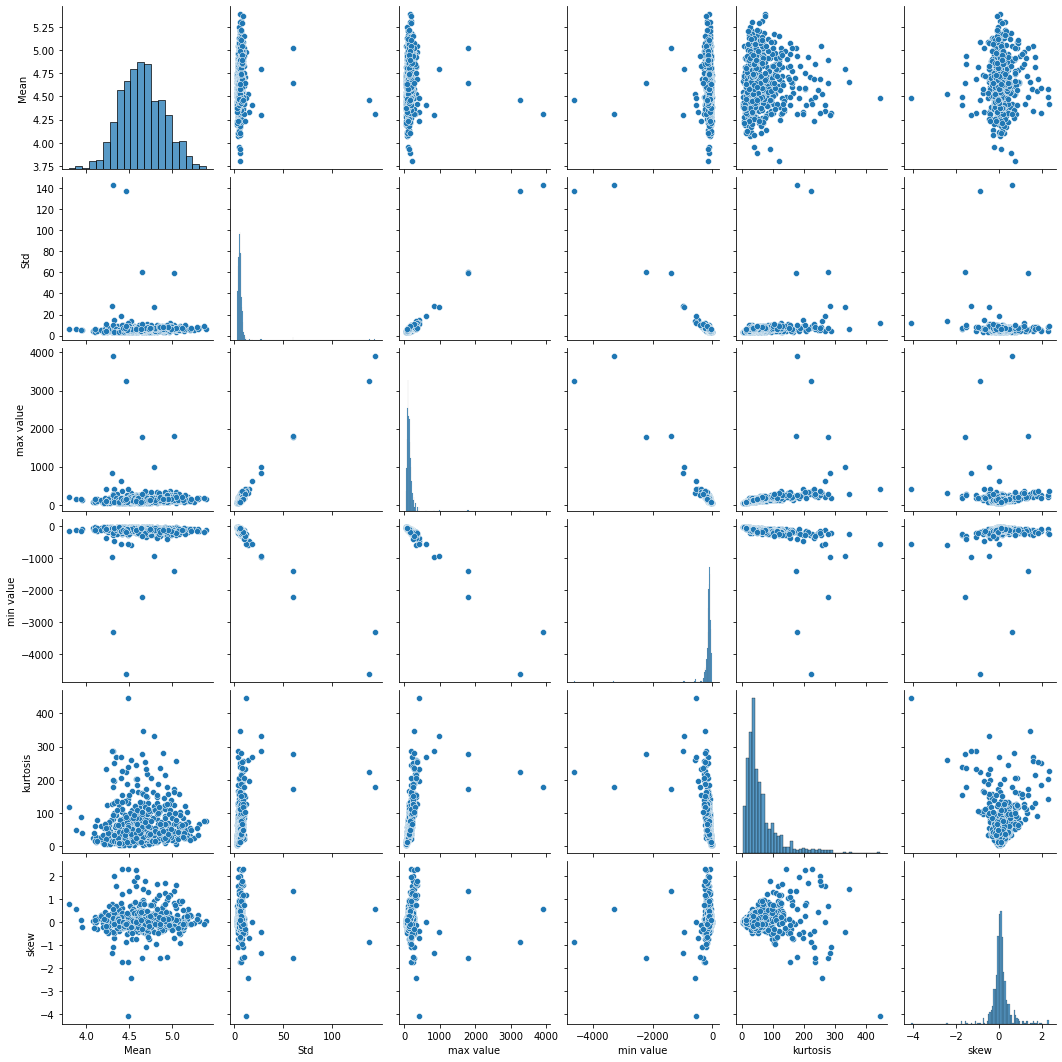

In [ ]:
sns.pairplot(x)

From the pair plot, we can see that Std is correlated with max value and min value. 

Mean variable is right skewed with Std and max value variable and left skewed with min value variable. 

Max value and min value feature are also correlated to each other.

#Scatter plot of new features.

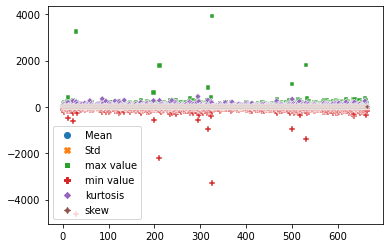

In [ ]:
sns.scatterplot(data=x)

Some features like max and min value have large outliers.

Q-Q plot of new features

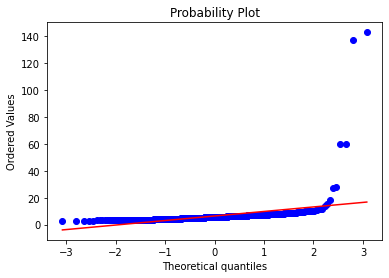

In [ ]:
from scipy import stats
import scipy
scipy.stats.probplot(x["Std"], plot=plt)
plt.show()

STD vaiable is normaly distributed between -2 to 2

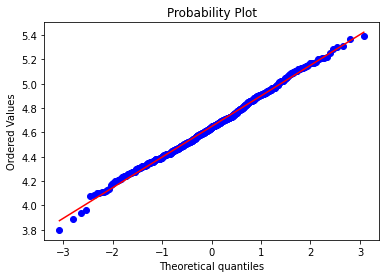

In [ ]:
scipy.stats.probplot(x["Mean"], plot=plt)
plt.show()

Mean variable is normaly distributed in our dataset

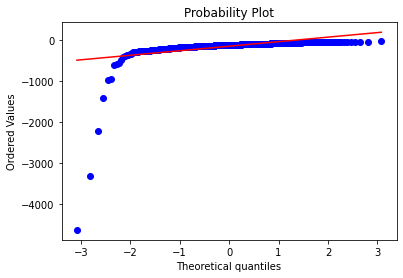

In [ ]:
scipy.stats.probplot(x["min value"], plot=plt)
plt.show()

Min value is left skewed

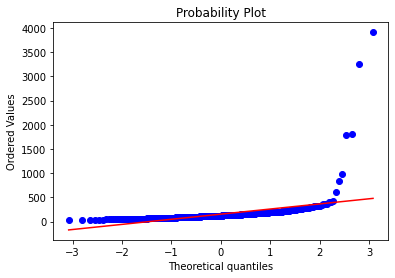

In [ ]:
scipy.stats.probplot(x["max value"], plot=plt)
plt.show()

Max value is right skewed

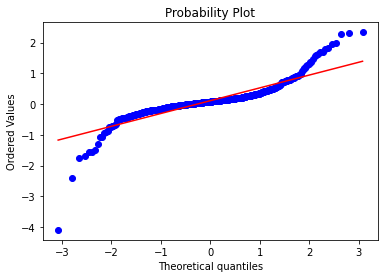

In [ ]:
scipy.stats.probplot(x["skew"], plot=plt)
plt.show()

Skew is normaly distributed with peaked value in the middle

In [ ]:
x["max value"].unique()

array([ 104,  181,  140,  197,  145,  142,  120,  139,  168,  152,  245,
        410,  224,   98,  126,  101,  146,  229,  313,  108,   84,  115,
        131,  118,  194, 3252,  159,  220,   60,   54,   72,   49,   38,
        119,  100,  133,   56,   76,   73,   64,  136,   42,  103,  170,
        111,   75,   97,  125,   71,   41,  214,   59,  123,   77,   52,
        124,   95,   87,   50,   57,   90,  127,   61,  157,  150,  185,
        273,  208,  110,   53,   93,  199,   74,  144,   55,  215,   92,
        148,  188,   85,  105,   99,   78,  249,  158,  113,  176,  230,
        154,  143,  165,  174,  121,   89,   86,  106,   83,  116,  192,
        151,  138,   45,   80,   68,   67,  160,  210,   88,  292,  156,
        135,  134,  114,   79,  248,  186,  161,  183,  206,  166,  155,
        618,  122,  172, 1787,  117,   94,  213,  202,  198,  109,  107,
         91,  162,  128,  289,  272,  243,  262,  297,  211,  147,  218,
        178,   82,  141,  359,  187,  180,  275,  1

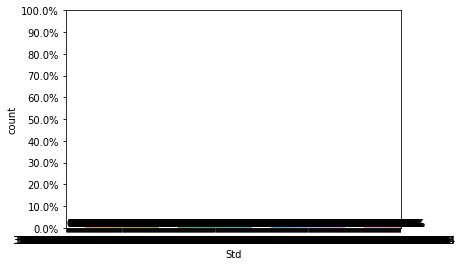

In [ ]:
%matplotlib inline
total = len(x)*1.
ax=sns.countplot(x="Std", data= x)
for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))

ax.yaxis.set_ticks(np.linspace(0, total, 11))

ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))
plt.show()

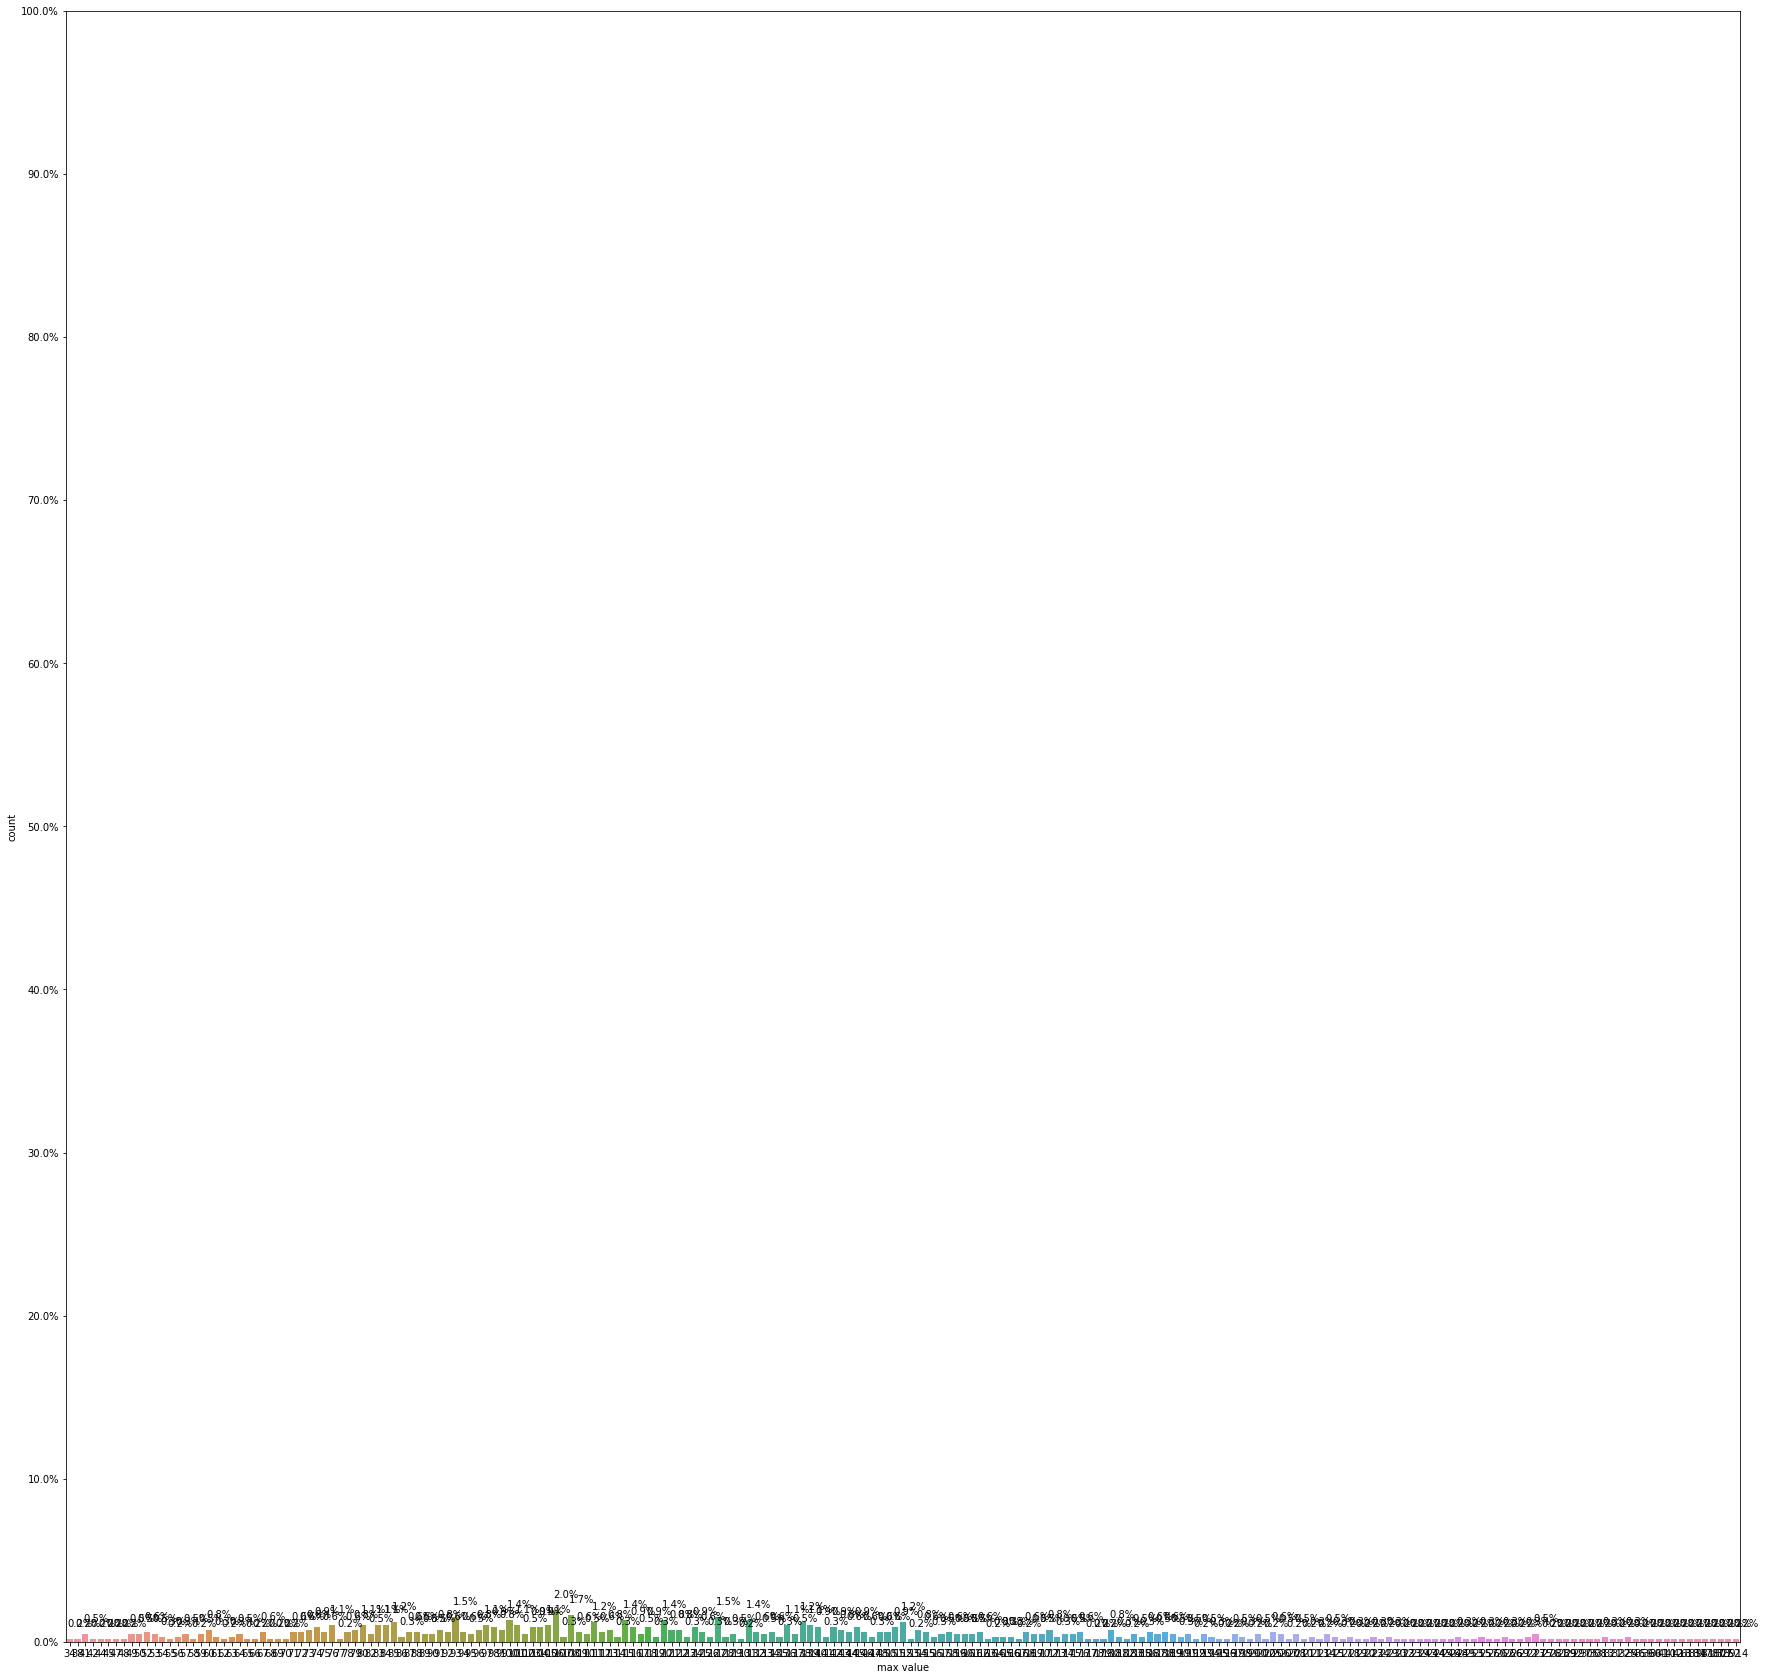

In [ ]:
%matplotlib inline
plt.figure(figsize=(30 , 30))
total = len(x)*1.
ax=sns.countplot(x="max value", data= x)
for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))

ax.yaxis.set_ticks(np.linspace(0, total, 11))

ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))
plt.show()

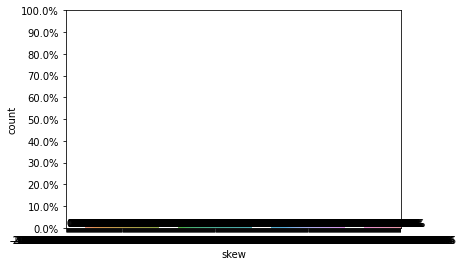

In [ ]:
%matplotlib inline
total = len(x)*1.
ax=sns.countplot(x="skew", data= x)
for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))

ax.yaxis.set_ticks(np.linspace(0, total, 11))

ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))
plt.show()

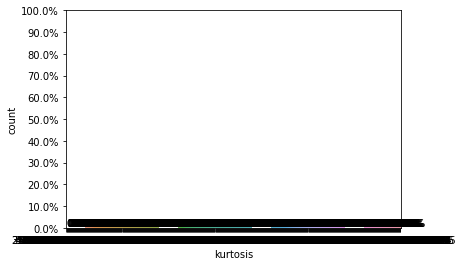

In [ ]:
%matplotlib inline
total = len(x)*1.
ax=sns.countplot(x="kurtosis", data= x)
for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))

ax.yaxis.set_ticks(np.linspace(0, total, 11))

ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))
plt.show()

Except Max and min value, other features like Mean, Kurtosis, skew etc are evenly distributed. 

If we remove the outliers, we will see the plots more clearly and the above statement will make more sense.

#Looking for outliers

#Box plot

[Text(0.5, 1.0, 'Box plot of acoustic data')]

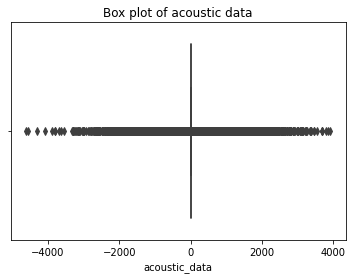

In [ ]:
sns.boxplot(x=df["acoustic_data"]).set(title='Box plot of acoustic data')

[Text(0.5, 1.0, 'Box plot of failure data')]

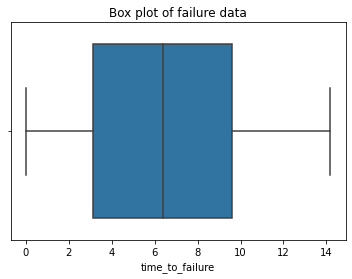

In [ ]:
sns.boxplot(x=df["time_to_failure"]).set(title='Box plot of failure data')

We can't see 25th, 50th or 75th percentile values of aucostic data but we can clearly see that there are many outliers. 

Using percentile value we will remove the outliers.

##Box plot of new features

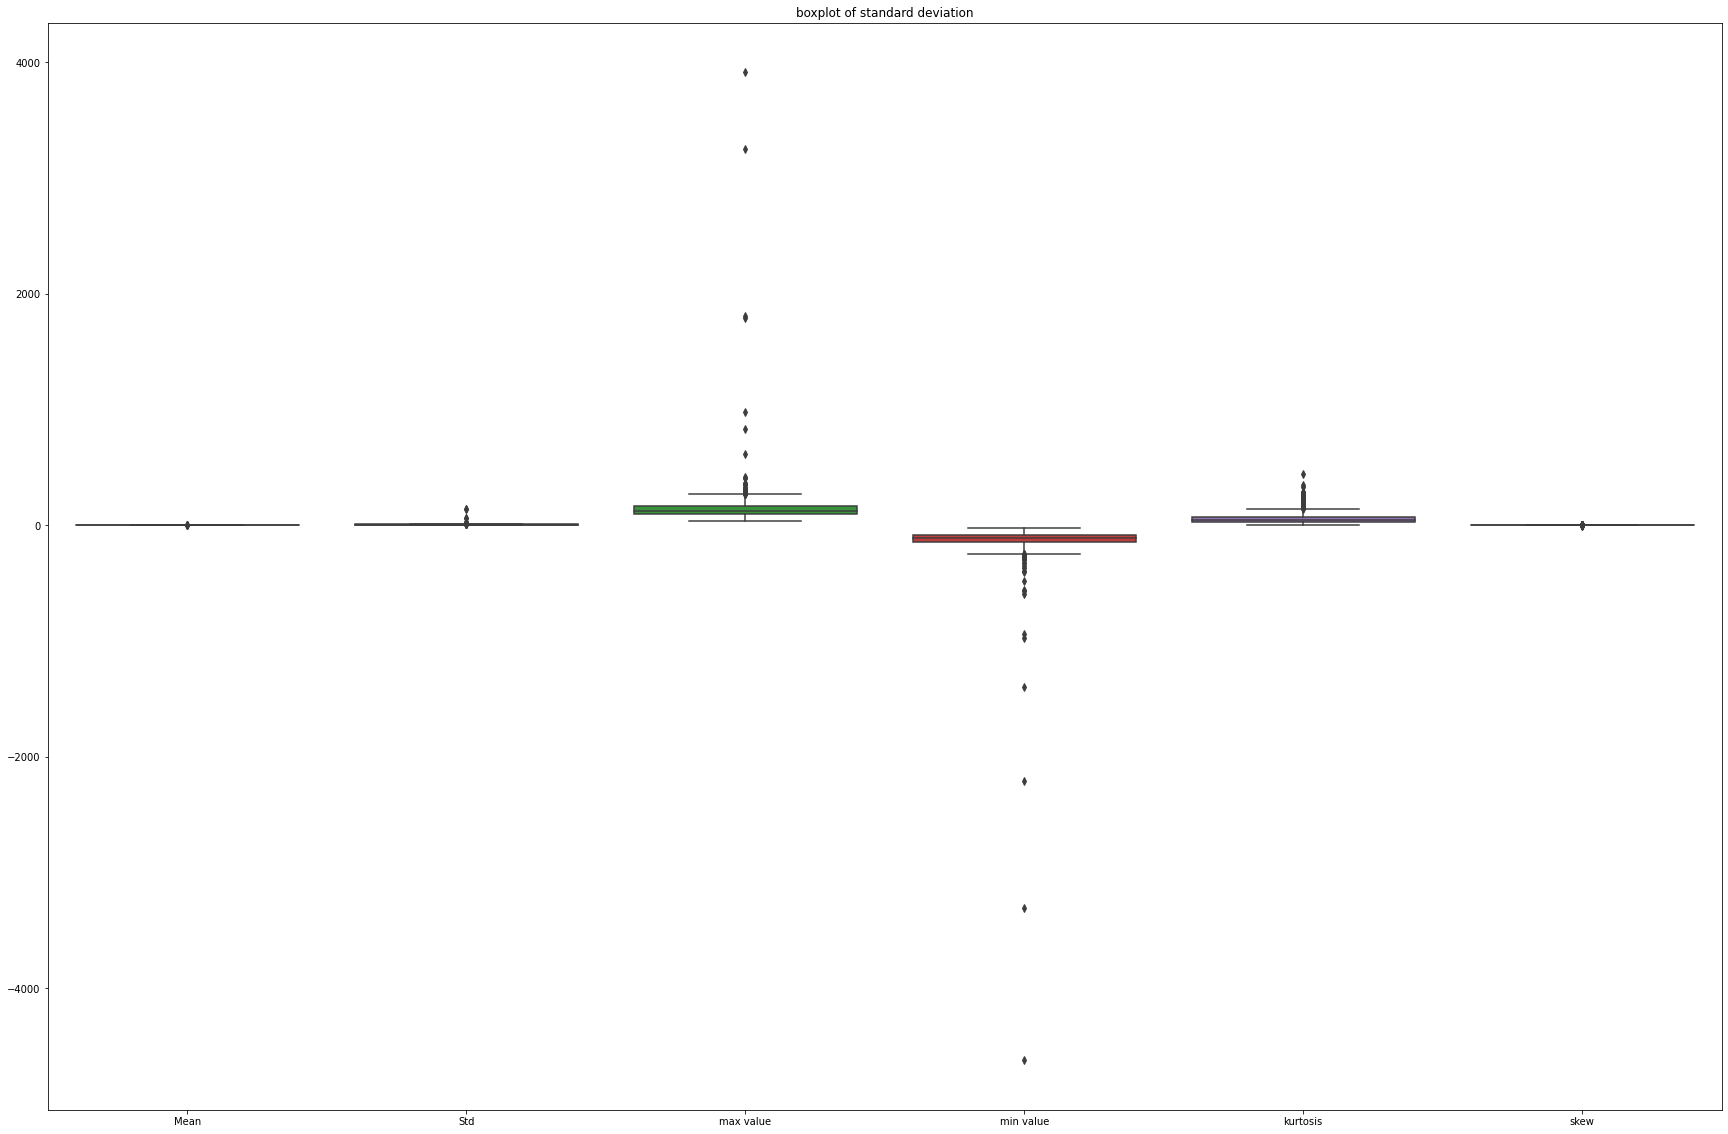

In [ ]:
plt.figure(figsize=(30 , 20))
ax = sns.boxplot(data=x)
plt.title("boxplot of standard deviation")
plt.show()

Max value and min value has most number of outliers.

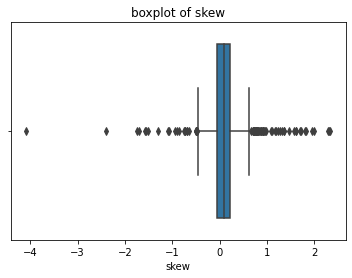

In [ ]:
ax = sns.boxplot(x="skew", data=x)
plt.title("boxplot of skew")
plt.show()

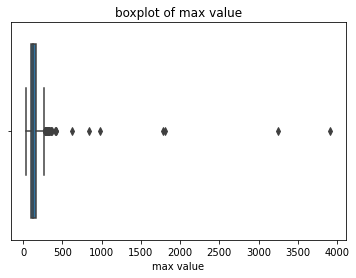

In [ ]:
ax = sns.boxplot(x="max value", data=x)
plt.title("boxplot of max value")
plt.show()

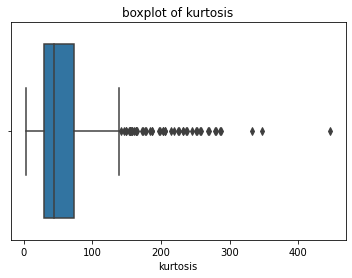

In [ ]:
ax = sns.boxplot(x="kurtosis", data=x)
plt.title("boxplot of kurtosis")
plt.show()

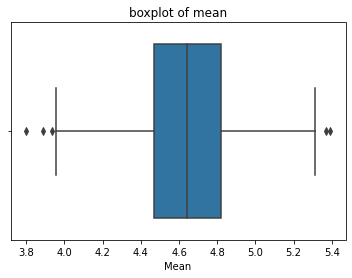

In [ ]:
ax = sns.boxplot(x="Mean", data=x)
plt.title("boxplot of mean")
plt.show()

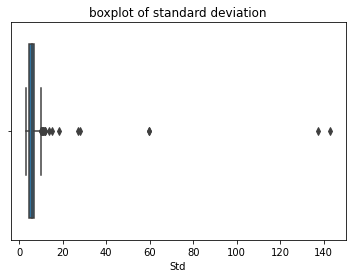

In [ ]:
ax = sns.boxplot(x="Std", data=x)
plt.title("boxplot of standard deviation")
plt.show()

From the box plot we can see that there are very few data present after and before the max and minimum range of box plot respectivly. They are the outliers.

#Plot of Acoustic data and Time To Failure 

In [ ]:
zz = df.sample(frac = 0.01)

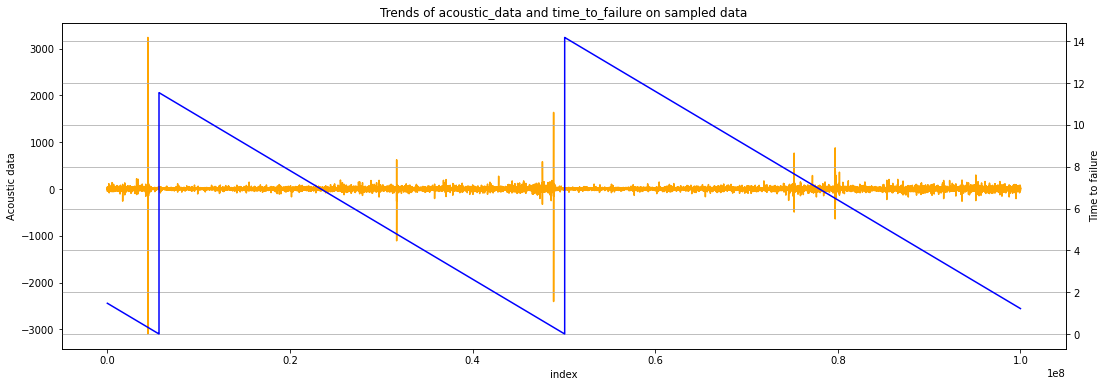

In [ ]:
#https://www.geeksforgeeks.org/matplotlib-axes-axes-twinx-in-python/
fig, ax1 = plt.subplots(figsize=(18, 6))
ax2 = ax1.twinx()
ax1.set_xlabel('index')
ax1.set_ylabel('Acoustic data')
ax2.set_ylabel('Time to failure')
plt.title("Trends of acoustic_data and time_to_failure on sampled data")
p1 = sns.lineplot(data = zz["acoustic_data"], ax=ax1, color='orange')
p2 = sns.lineplot(data = zz["time_to_failure"], ax=ax2 , color = 'blue')
plt.grid()

We can see that as the time vaiable gets maxed out, we get an earthquake.

#Percentiles

In [ ]:
5//100

0.05

In [ ]:
for i in range(0 , 105 , 5):
  print(i , "th percentile value is" , df["acoustic_data"].quantile(i/100))

0 th percentile value is -4621.0
5 th percentile value is -2.0
10 th percentile value is 0.0
15 th percentile value is 1.0
20 th percentile value is 2.0
25 th percentile value is 2.0
30 th percentile value is 3.0
35 th percentile value is 3.0
40 th percentile value is 4.0
45 th percentile value is 4.0
50 th percentile value is 5.0
55 th percentile value is 5.0
60 th percentile value is 5.0
65 th percentile value is 6.0
70 th percentile value is 6.0
75 th percentile value is 7.0
80 th percentile value is 8.0
85 th percentile value is 8.0
90 th percentile value is 9.0
95 th percentile value is 11.0
100 th percentile value is 3914.0


In [ ]:
for i in range(90 , 101):
  print(i , "th percentile value is" , df["acoustic_data"].quantile(i/100))

90 th percentile value is 9.0
91 th percentile value is 10.0
92 th percentile value is 10.0
93 th percentile value is 10.0
94 th percentile value is 11.0
95 th percentile value is 11.0
96 th percentile value is 12.0
97 th percentile value is 13.0
98 th percentile value is 15.0
99 th percentile value is 20.0
100 th percentile value is 3914.0


In [ ]:
#https://www.edureka.co/community/47748/is-there-a-way-to-loop-between-0-and-1-by-0-1-in-python
a = np.linspace(99,100,11)
for i in a:
  print(i , "th percentile value is" , df["acoustic_data"].quantile(i/100))

99.0 th percentile value is 20.0
99.1 th percentile value is 21.0
99.2 th percentile value is 22.0
99.3 th percentile value is 24.0
99.4 th percentile value is 25.0
99.5 th percentile value is 28.0
99.6 th percentile value is 31.0
99.7 th percentile value is 35.0
99.8 th percentile value is 41.0
99.9 th percentile value is 55.0
100.0 th percentile value is 3914.0


In [ ]:
a = np.linspace(0,3 , 20)
for i in a:
  print(i , "th percentile value is" , df["acoustic_data"].quantile(i/100))

0.0 th percentile value is -4621.0
0.15789473684210525 th percentile value is -36.0
0.3157894736842105 th percentile value is -24.0
0.47368421052631576 th percentile value is -19.0
0.631578947368421 th percentile value is -15.0
0.7894736842105263 th percentile value is -13.0
0.9473684210526315 th percentile value is -11.0
1.1052631578947367 th percentile value is -10.0
1.263157894736842 th percentile value is -9.0
1.4210526315789473 th percentile value is -8.0
1.5789473684210527 th percentile value is -7.0
1.7368421052631577 th percentile value is -7.0
1.894736842105263 th percentile value is -6.0
2.052631578947368 th percentile value is -6.0
2.2105263157894735 th percentile value is -5.0
2.3684210526315788 th percentile value is -5.0
2.526315789473684 th percentile value is -5.0
2.6842105263157894 th percentile value is -4.0
2.8421052631578947 th percentile value is -4.0
3.0 th percentile value is -4.0


After computing the percentiles, we can clearly see that there are outliers present in the dataset

Because after seeing the percentile, from 99.8 percentile value the values are range far away from the maximum points. So, its better to ignore them.

Similarly we can ignore points which are less tha -2.0 or points which are below the 5th percentile.

#Multi variant analysis

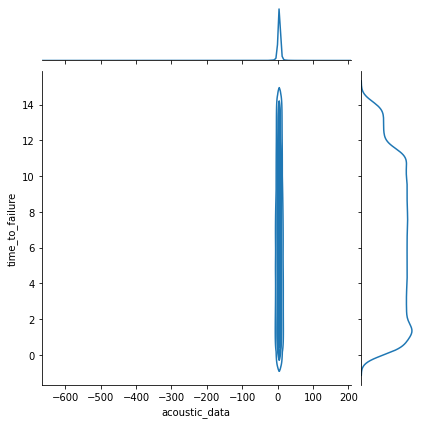

In [ ]:
sns.jointplot(x="acoustic_data", y="time_to_failure", data = df.sample(frac = 0.001), kind="kde");
plt.show()

Here is a bivariate density plot with 0.1% of data. 
The acoustic data is very narrow where as time to failure is wide.
The 0.1% of acoustic is narrow but has few large points, indicating the outliers. 


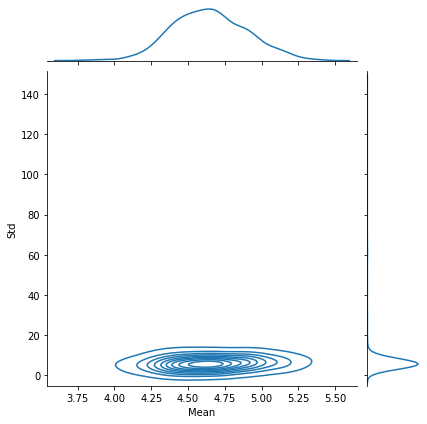

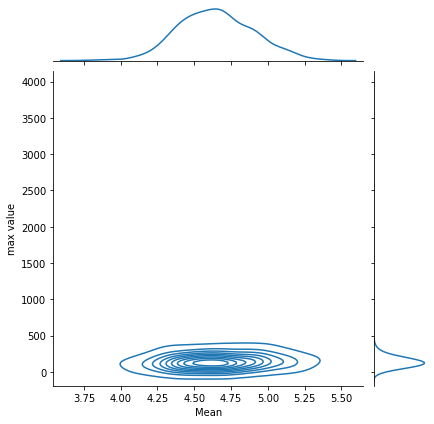

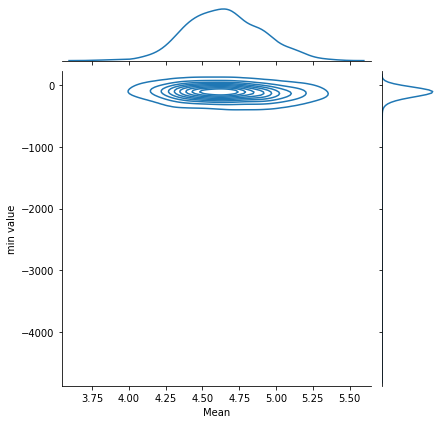

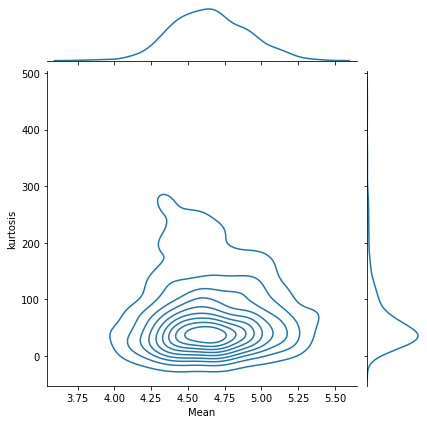

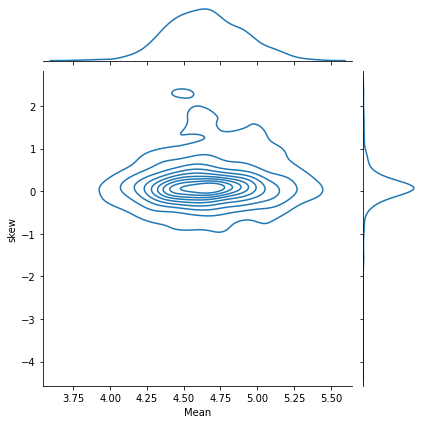

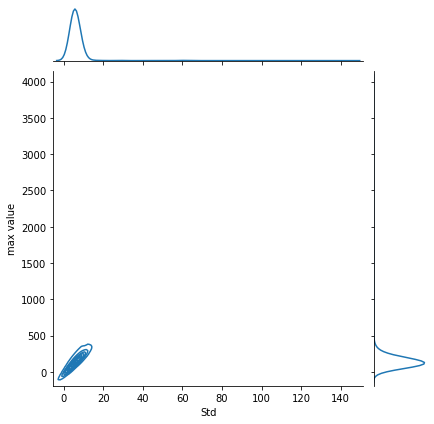

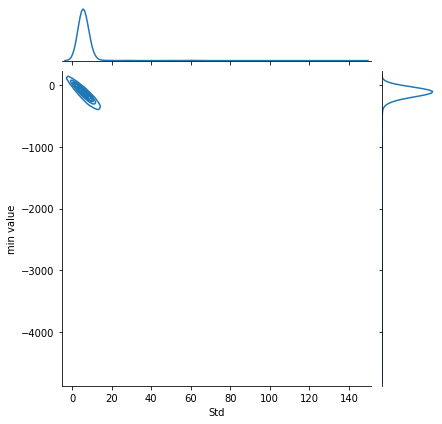

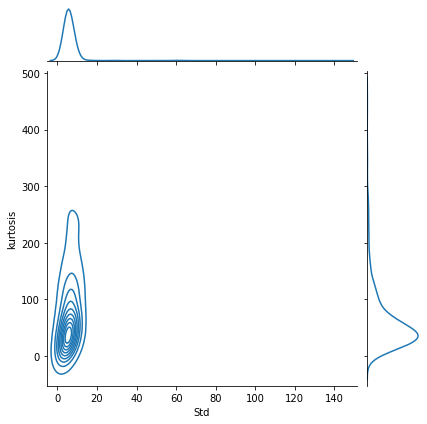

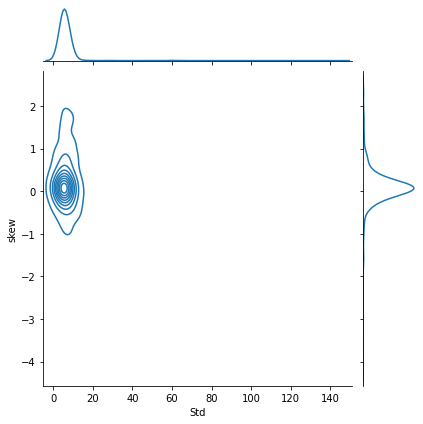

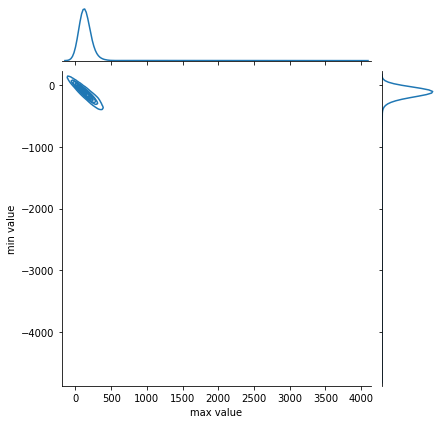

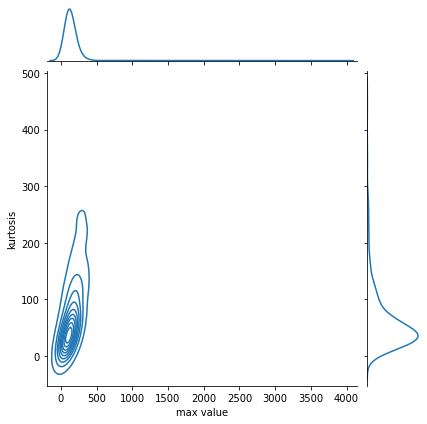

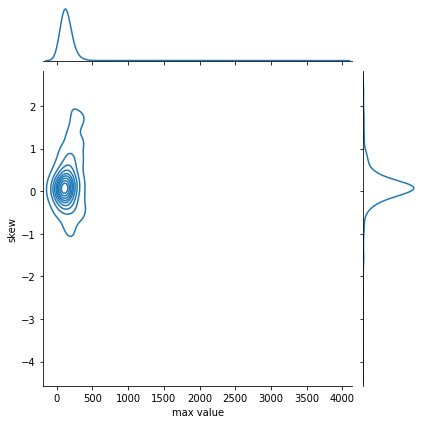

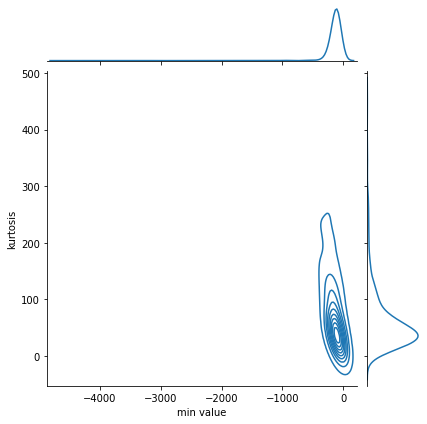

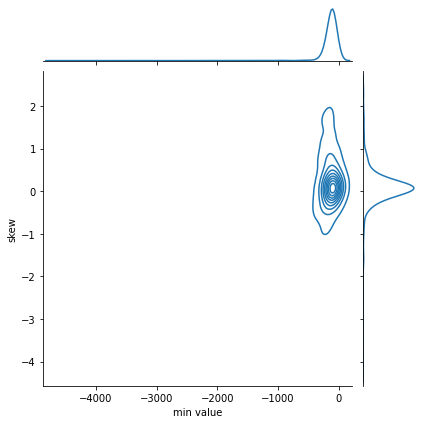

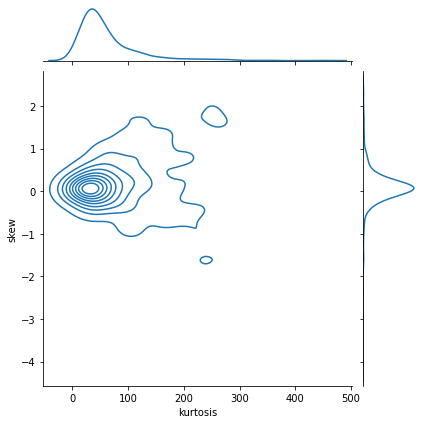

In [ ]:
"""for i in  feat.columns[:-1]:
  for j in feat.columns[:-1]:
    if i!=j:
      sns.jointplot(x= i , y=j, data = feat, kind="kde");
      plt.show();
    else:
      pass
"""
pair = []
for i in  feat.columns[:-1]:
  for j in feat.columns[:-1]:
    if i!=j:
      if [j,i] not in pair:
        pair.append([i,j])
        sns.jointplot(x= i , y=j, data = feat, kind="kde");
        plt.show()
        
    else:
      pass

Because of the outliers present in the orginal data, we can see it was affected the new data that we created.

##Removing outliers

In [ ]:
dataframe = df[(df["acoustic_data"] >-2.0) & (df["acoustic_data"]<41.0)]

In [ ]:
dataframe.head(3)

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691


In [ ]:
dataframe.shape

(94020672, 2)